In [12]:
from datetime import datetime
import os
import warnings

import heliopy.data.omni as omni
from matplotlib import pyplot as plt
import optuna
from optuna import visualization as viz
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import ks_2samp
from tensorflow import keras

from typing import *

warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [56]:
START_TIME_CYCLE_21 = datetime(1976, 3, 1)  
START_TIME_CYCLE_22 = datetime(1986, 9, 1)  
START_TIME_CYCLE_23 = datetime(1996, 8, 1)  
START_TIME_CYCLE_24 = datetime(2008, 12, 1)  
START_TIME_CYCLE_25 = datetime(2019, 12, 1)

INPUT_LENGTH = 24

In [3]:
def get_omni_rtn_data(start_time, end_time):
    identifier = 'OMNI_COHO1HR_MERGED_MAG_PLASMA'  # COHO 1HR data
    omni_data = omni._omni(start_time, end_time, identifier=identifier, intervals='yearly', warn_missing_units=False)
    return omni_data

In [133]:
data_train = get_omni_rtn_data(START_TIME_CYCLE_21, START_TIME_CYCLE_23).to_dataframe()
data_val = get_omni_rtn_data(START_TIME_CYCLE_23, START_TIME_CYCLE_24).to_dataframe()
data_test = get_omni_rtn_data(START_TIME_CYCLE_24, START_TIME_CYCLE_25).to_dataframe()

mag_field_strength_train = np.array(data_train["BR"])
mag_field_strength_val = np.array(data_val["BR"])
mag_field_strength_test = np.array(data_test["BR"])

In [57]:
data_train_cycle_1 = get_omni_rtn_data(START_TIME_CYCLE_21, START_TIME_CYCLE_22).to_dataframe()
data_train_cycle_2 = get_omni_rtn_data(START_TIME_CYCLE_22, START_TIME_CYCLE_23).to_dataframe()

mag_field_strength_train_1 = np.array(data_train_cycle_1["BR"])
mag_field_strength_train_2 = np.array(data_train_cycle_2["BR"])

### Dataset Checks

### Mag Field Strength Hists

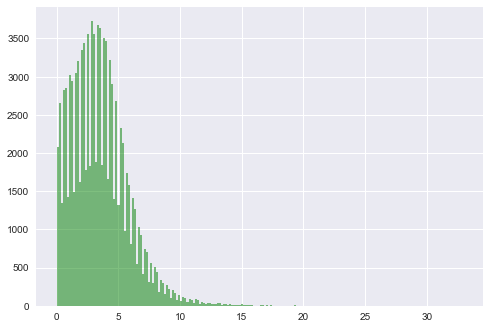

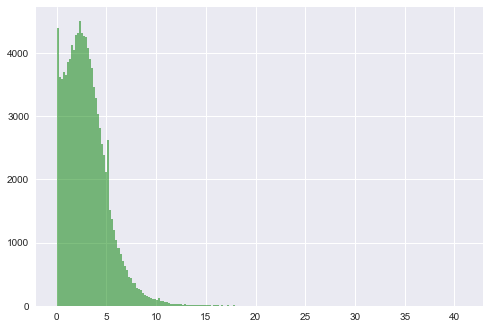

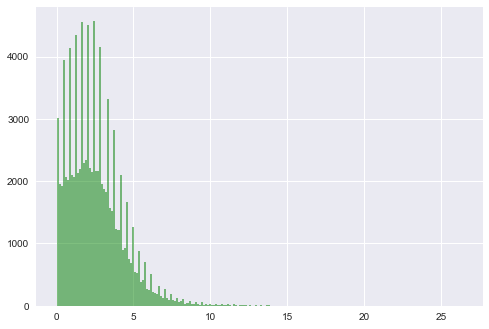

In [134]:
for dset in [mag_field_strength_train, mag_field_strength_val, mag_field_strength_test]:
    plt.hist(np.abs(dset), color="green", alpha=0.5, label="train", bins=200)
    plt.show()

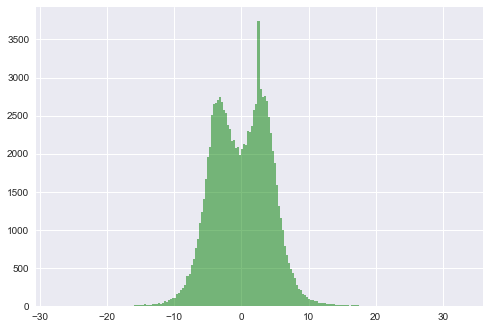

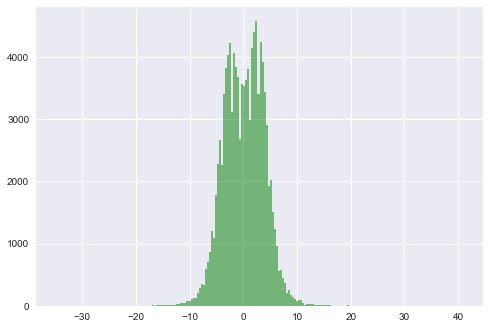

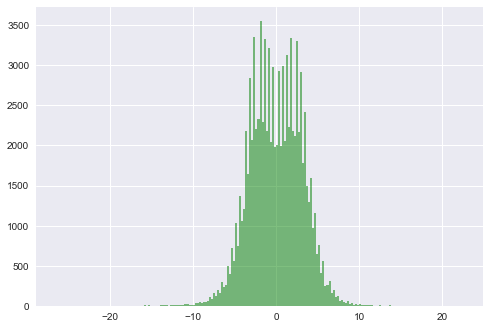

In [135]:
for dset in [mag_field_strength_train, mag_field_strength_val, mag_field_strength_test]:
    plt.hist(dset, color="green", alpha=0.5, label="train", bins=200)
    plt.show()

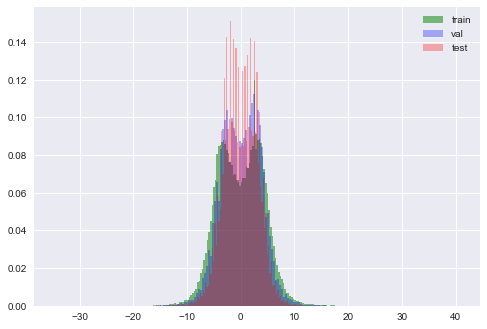

In [75]:
plt.hist(mag_field_strength_train, color="green", alpha=0.5, label="train", bins=200, density=True)
plt.hist(mag_field_strength_val, color="blue", alpha=0.3, label="val", bins=200, density=True)
plt.hist(mag_field_strength_test, color="red", alpha=0.3, label="test", bins=200, density=True)
plt.legend()
plt.show()

### Check - are two cycles in training set v different? Answer: No

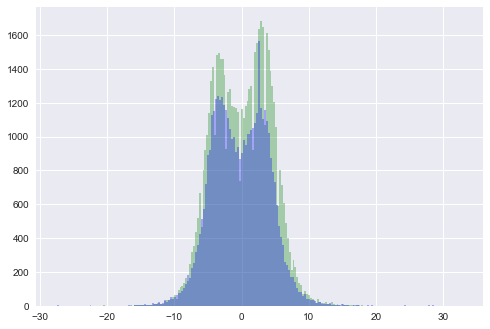

In [138]:
plt.hist(mag_field_strength_train_1, color="green", alpha=0.3, label="train", bins=200)
plt.hist(mag_field_strength_train_2, color="blue", alpha=0.3, label="train", bins=200)
plt.show()

### Plot time series

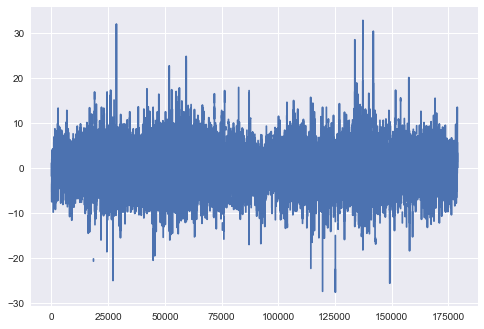

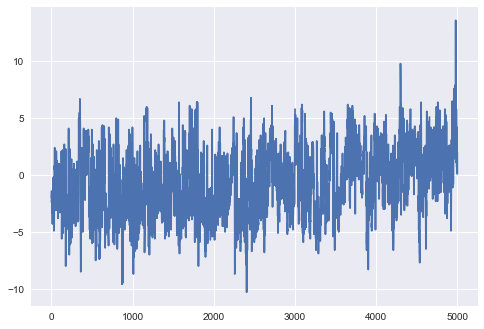

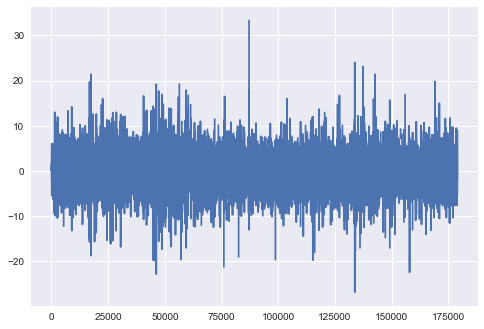

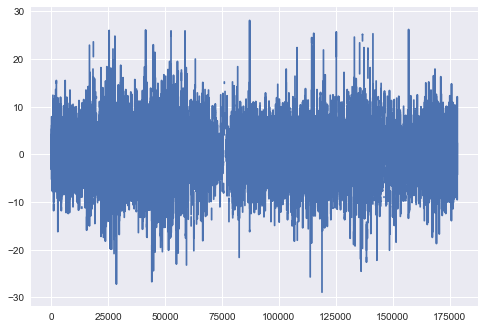

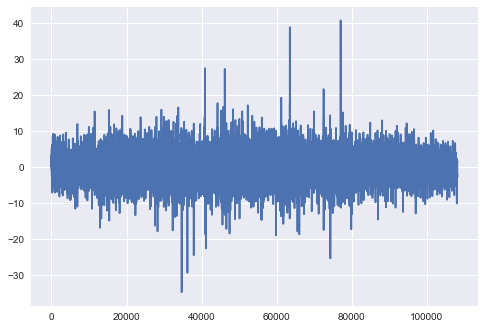

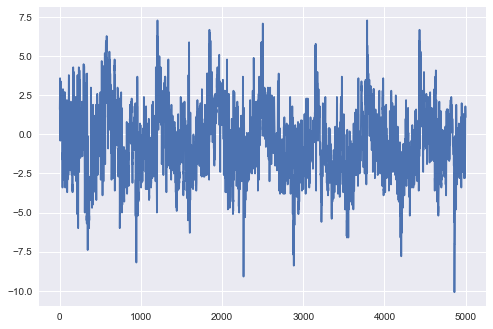

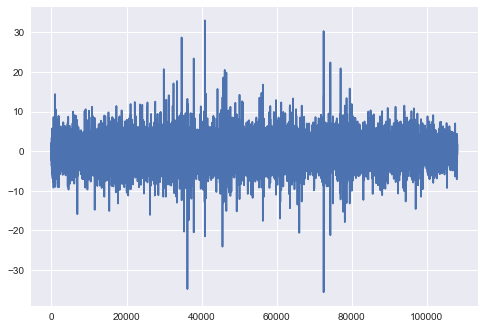

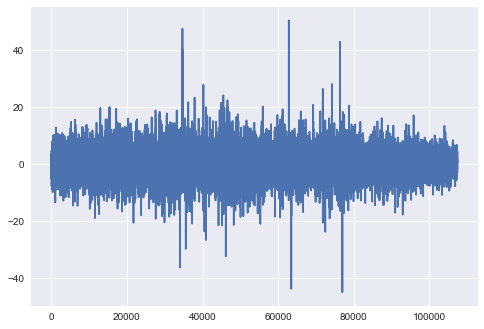

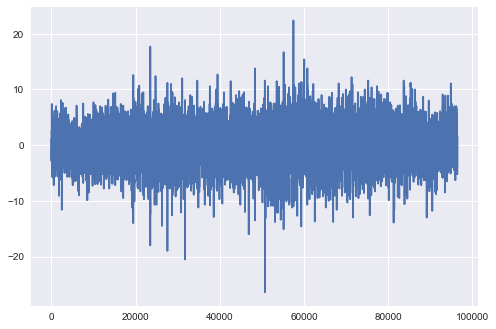

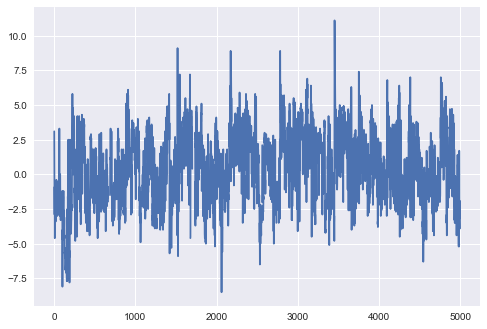

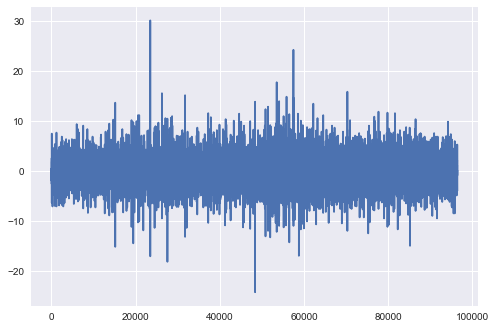

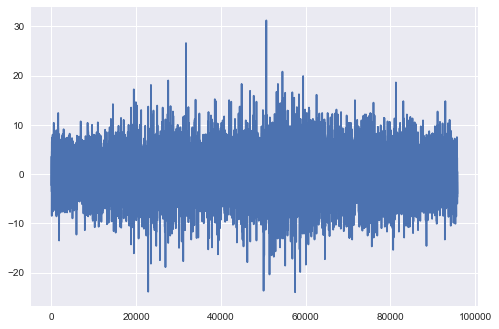

In [122]:
for dset in [mag_field_strength_train, mag_field_strength_val, mag_field_strength_test]:
    plt.plot(dset)
    plt.show()
    plt.plot(dset[-5000:])
    plt.show()
    plt.plot(dset[1:] - dset[:-1])
    plt.show()
    plt.plot(dset[648:] - dset[:-648])
    plt.show()
    print("")

### Autocorrelation

In [111]:
autocorrs = []
for lag in range(10000):
    autocorrs.append(data_train["BR"].autocorr(lag=lag))

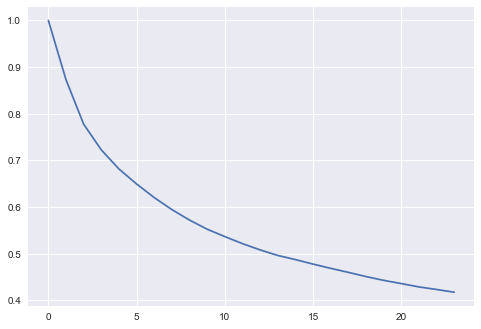

In [128]:
plt.plot(autocorrs[:24])

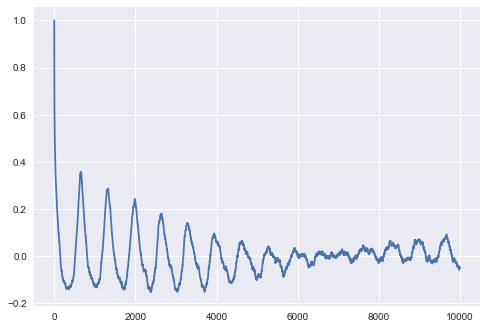

In [127]:
plt.plot(autocorrs)

In [117]:
peaks = find_peaks(autocorrs, prominence=0.1)[0]

In [119]:
peaks[1:] - peaks[:-1]

array([ 669,  660,  656,  636,  666,  682,  650, 3722,  668])

### Training set NaNs

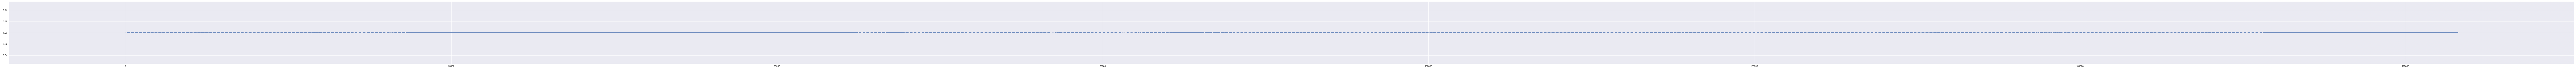

In [44]:
plt.figure(figsize=(200, 5))
plt.scatter(np.where(mag_field_strength_train == mag_field_strength_train)[0],
            np.zeros(len(np.where(mag_field_strength_train == mag_field_strength_train)[0])), 
            s=3)
plt.show()

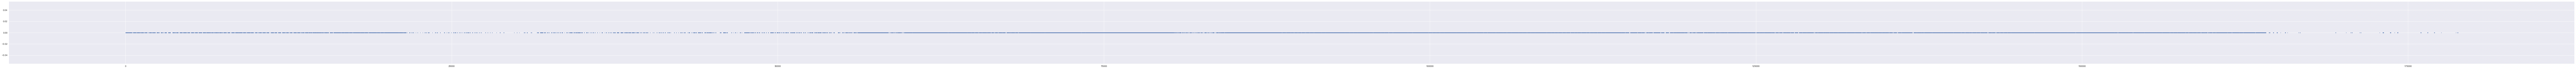

In [43]:
plt.figure(figsize=(200, 5))
plt.scatter(np.where(mag_field_strength_train != mag_field_strength_train)[0],
            np.zeros(len(np.where(mag_field_strength_train != mag_field_strength_train)[0])), 
            s=3)
plt.show()

### Summary Stats

In [45]:
for name, dset in zip(["Train", "Val", "Test"], 
                      [mag_field_strength_train, mag_field_strength_val, mag_field_strength_test]):
    print("{} non-nan:".format(name), np.count_nonzero(~np.isnan(dset)))
    print("{} % non-nan:".format(name), 100 * np.count_nonzero(~np.isnan(dset)) / len(dset))
    print("{} mean:".format(name), np.nanmean(dset))
    print("{} std:".format(name), np.nanstd(dset))
    print("")

Train non-nan: 103189
Train % non-nan: 57.643943668266196
Train mean: -0.025585102
Train std: 4.2038527

Val non-nan: 107914
Val % non-nan: 99.79931749452054
Val mean: 0.0997359
Val std: 3.731814

Test non-nan: 96310
Test % non-nan: 99.88798772013524
Test mean: -0.019854631
Test std: 3.0799603



In [72]:
def lstm_prepare_1d(mag_field_strength, input_length=INPUT_LENGTH):
    inputs = np.array([mag_field_strength[i:i + input_length] 
                             for i in range(len(mag_field_strength) - input_length)])[:, :, np.newaxis]
    outputs = np.array(mag_field_strength[input_length:])

    nan_check = np.array([mag_field_strength[i:i + input_length + 1] 
                          for i in range(len(mag_field_strength) - input_length)])

    inputs = inputs[np.where([~np.any(np.isnan(i)) for i in nan_check])]
    outputs = outputs[np.where([~np.any(np.isnan(i)) for i in nan_check])]

    print("Input shape:", inputs.shape)
    print("Output shape:", outputs.shape)
    print("Any Nans?:", np.any(np.isnan(outputs)) or np.any(np.isnan(inputs)))
    print("")
    return inputs, outputs

In [73]:
inputs_train, outputs_train = lstm_prepare_1d(mag_field_strength_train)
inputs_val, outputs_val = lstm_prepare_1d(mag_field_strength_val)
inputs_test, outputs_test = lstm_prepare_1d(mag_field_strength_test)

Input shape: (41366, 24, 1)
Output shape: (41366,)
Any Nans?: False

Input shape: (107342, 24, 1)
Output shape: (107342,)
Any Nans?: False

Input shape: (96036, 24, 1)
Output shape: (96036,)
Any Nans?: False



#### The above suggests to swap train and val sets 

### KS-Test (Distribution Comparisons)

In [86]:
mag_field_strength_train_nonan = mag_field_strength_train[mag_field_strength_train == mag_field_strength_train]
mag_field_strength_val_nonan = mag_field_strength_val[mag_field_strength_val == mag_field_strength_val]
mag_field_strength_test_nonan = mag_field_strength_test[mag_field_strength_test == mag_field_strength_test]

In [87]:
print("Train vs Val:", ks_2samp(mag_field_strength_train_nonan, mag_field_strength_val_nonan).pvalue)
print("Train vs Test:", ks_2samp(mag_field_strength_train_nonan, mag_field_strength_test_nonan).pvalue)
print("Val vs Test:", ks_2samp(mag_field_strength_val_nonan, mag_field_strength_test_nonan).pvalue)

Train vs Val: 1.383808721000921e-181
Train vs Test: 0.0
Val vs Test: 5.984831895838384e-166


In [124]:
mag_field_strength_train_1_nonan = mag_field_strength_train_1[mag_field_strength_train_1 == mag_field_strength_train_1]
mag_field_strength_train_2_nonan = mag_field_strength_train_2[mag_field_strength_train_2 == mag_field_strength_train_2]
print("Train1 vs Train2:", ks_2samp(mag_field_strength_train_1_nonan, mag_field_strength_train_2_nonan).pvalue)

Train1 vs Train2: 7.596348762593442e-47


### Main takeaways so far:
- Strong seasonality every 27 days (which makes sense due to this being a solar cycle). Can we use this?
- Many NaNs in training - let's swap train and val 
- Distributions of the 3 datasets visually aren't massively different but statistically are very different. Need to think about what this means for our analysis. 
- Question for Sid: why are there two peaks in each plot of the distributions? Answer: due to sign flip - if you take absolute value there's only one peak.
- Question for Sid: reminder: this is just the absolute magnetic field strength? Irrelevant of coordinates and stuff? Answer: not quite absolute - it's the strength at one particular point, and the sun rotates, so it's always a different point until a full rotation happens. Full rotation is every ~27 days, which is why we get these spikes in the autocorrelation plot. So, it's ok to predict the next 24 hours as the point doesn't really change tooooo much, but this dataset shouldn't be used for long-term as the point will be too different. 

In [ ]:
# next steps:
# make training set cycle 21 and cycle 23, val cycle 22, test cycle 24
# try dilated conv with 27 day dilation, plus the 24 hour lstm and make it one large network
# Put on hold AnEn + classification problem 
# Do some writeup- see Sid's branch in notes.tex. Will have to download latex. 